## The Jackknife, Bootstrap, and Poisson Bootstrap

### Paul Anzel 11/11/15

If we're trying to figure out some statistic $\mu$ about our data (mean, standard deviation, IQR) we'd like to have some estimates of how good these statistics are. Or maybe we just want some estimate of what we think our distribution looks like.

Here's a few techniques to use, which generally involve resampling on your data into some new set and recomputing $\mu$ on that.

Note that we're working on stationary, IID data.

In [1]:
from __future__ import division, print_function
import numpy as np
import numpy.random as rd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('white')

In [2]:
### Establish data set

N = 400
norm1 = stats.norm(loc=1.5, scale=.5)
norm2 = stats.norm(loc=-1.5, scale=1)

X = np.concatenate([norm1.rvs(N/2), norm2.rvs(N/2)])

x_example = np.linspace(-5, 5, num=101)
y_example = (norm1.pdf(x_example) + norm2.pdf(x_example))/2

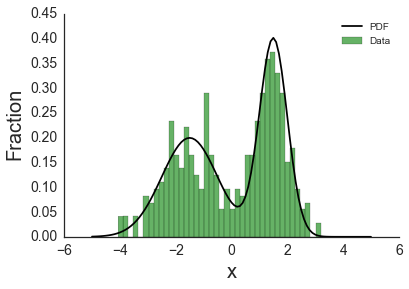

In [3]:
plt.hist(X, bins=40, normed=True, facecolor='g', alpha=.6)
plt.plot(x_example, y_example, color='k')
plt.xlabel('x', fontsize=20)
plt.ylabel('Fraction', fontsize=20)
plt.legend(['PDF', 'Data'])
plt.tick_params(labelsize=14)
sns.despine()

### The Jackknife

We'll be doing the same Leave-One-Out technique$^{*}$ that we did in Cross-Validation, but instead of calculating the model fit we are calculating our statistic of interest.

$^{*}$You could also do things like Leave-p-Out or k-Fold.

Mean of jackknifed mean is 0.0096
Standard deviation on jackknifed mean is 0.0043


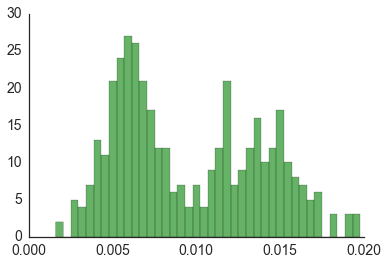

In [4]:
from sklearn import cross_validation
loo = cross_validation.LeaveOneOut(N)

meanvals_jn = np.empty(len(loo))

for idx, (train, _) in enumerate(loo):
    Xset = X[train]
    meanvals_jn[idx] = Xset.mean()    

print('Mean of jackknifed mean is %.4f' % meanvals_jn.mean()) 
print('Standard deviation on jackknifed mean is %.4f' % meanvals_jn.std())    

plt.hist(meanvals_jn, bins=40, facecolor='g', alpha=.6)
plt.tick_params(labelsize=14)
sns.despine()

### The Bootstrap

Instead of methodically dropping one point at a time, we instead randomly pick (with replacement$^{*}$) data points from our sample of $n$, making a new sample set $D$. Run the statistic $\mu_D$ on $D$. Repeat this $B$ times to get a distribution for the statistic $\mu$--the distribution of $\mu_D$ around $\mu$ should match that of your estimated statistic $\mu$ around it's real value.

$^{*}$So data points will very likely be repeated.

Mean of bootstrapped mean is 0.0074
Standard deviation on bootstrapped mean is 0.0859


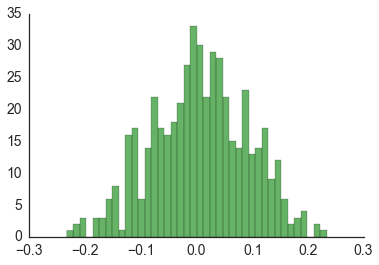

In [5]:
import sklearn

B_bs = 500
rd.seed(1337)

meanvals_bs = np.empty(B_bs)

for idx in range(B_bs):
    Dsample = sklearn.utils.resample(X)
    meanvals_bs[idx] = Dsample.mean()

plt.hist(meanvals_bs, bins=40, facecolor='g', alpha=.6)
print('Mean of bootstrapped mean is %.4f' % meanvals_bs.mean())
print('Standard deviation on bootstrapped mean is %.4f' % meanvals_bs.std())
plt.tick_params(labelsize=14)
sns.despine()

The bootstrap is also useful for trying to get an idea of the disribution of your random variable. Below, we're doing to do a Gaussian kernel-density-estimate$^*$ of the double Gaussian used to generate $X$, and then we're look at a few bootstraped KDEs to get an idea of the distribution.

$^*$You basically assume each point gives a little Gaussian around it to contribute to the distribution. Notes on different ways of implementing KDEs in Python available at https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

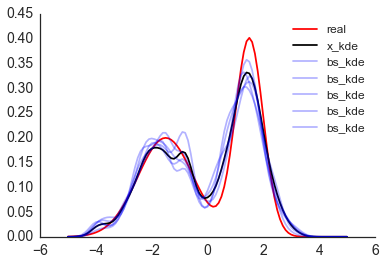

In [6]:
Xkde = stats.gaussian_kde(X, bw_method=0.15)
Xkde_fit = Xkde.evaluate(x_example)
plt.plot(x_example, y_example, color='r', label='real')
plt.plot(x_example, Xkde_fit, color='k', label='x_kde')

B_fit=5
rd.seed(54321)
for idx in range(B_fit):
    Dsample = sklearn.utils.resample(X)
    Dkde = stats.gaussian_kde(Dsample, bw_method=0.15)
    Dkde_fit = Dkde.evaluate(x_example)
    plt.plot(x_example, Dkde_fit, color='b', label='bs_kde', alpha=0.3)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
sns.despine()

### Jackknife versus Bootstrap

Jackknife:
- Always repeatable
- Faster
- Range of estimates smaller than Bootstrap by $\sqrt{N}$ for large $N$
- Better for determining bias of an estimator (since you're working with subsets) or quick-and-dirty analysis

Bootstrap:
- Need to set seed value for repeatability
- Can involve more analysis
- Better for finding statistical variance if your estimator
- Used for finding a possible distribution of the statistic
- Typically more used in these heady days of lots of computer power

### The Poisson Bootstrap

[An introduction to the Poisson Bootstrap](http://www.unofficialgoogledatascience.com/2015/08/an-introduction-to-poisson-bootstrap_26.html)

If we have a ton of data (that doesn't fit in just one computer) trying to select one sample from your whole set $n$ times is kind of a logistical nightmare. It would be nice if there was a way to have each server independently send you some set of values and you can just concatenate the list to run your statistics on. Hence the Poisson Bootstrap.

For a regular Bootstrap, the number of times data point $i$ shows up in the set is $Binomial(N, 1/N)$. 

$Binomial(N, 1/N) \Rightarrow p(k) = \frac{N!}{k!(N-k)!}(1/N)^k (1-1/N)^{N-k}$

When $N$ is large (in practice $N \geq 100$) $Binomial(N, 1/N) \rightarrow Poisson(1)$

$Poisson(1) \Rightarrow p(k) = \frac{1}{e \; k!}$

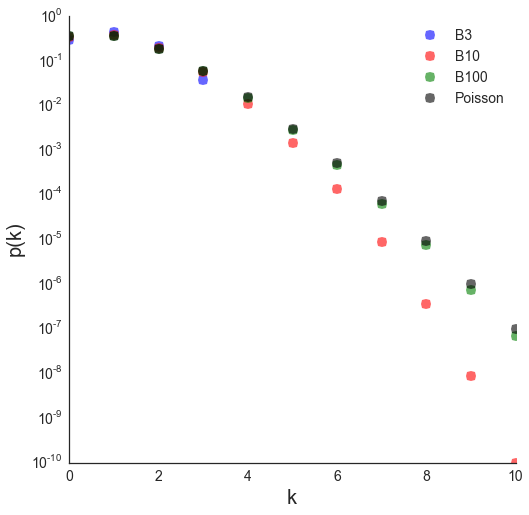

In [7]:
plt.figure(figsize=(8,8))

k_range = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
binomial10p = stats.binom.pmf(k_range, 10, 1/10)
binomial100p = stats.binom.pmf(k_range, 100, 1/100)
binomial3p = stats.binom.pmf(k_range, 3, 1/3)
poisson1p = stats.poisson.pmf(k_range, 1)

plt.semilogy(k_range, binomial3p, color='b', marker='o', markersize=10,
             alpha=.6, linestyle='', label='B3')
plt.semilogy(k_range, binomial10p, color='r', marker='o', markersize=10,
             alpha=.6, linestyle='', label='B10')
plt.semilogy(k_range, binomial100p, color='g', marker='o', markersize=10,
             alpha=.6, linestyle='', label='B100')
plt.semilogy(k_range, poisson1p, color='k', marker='o', markersize=10,
             alpha=.6, linestyle='', label='Poisson')
plt.legend(fontsize=14)
plt.xlabel('k', fontsize=20)
plt.ylabel('p(k)', fontsize=20)
plt.tick_params(labelsize=14)
sns.despine()

So the strategy is as follows: For each data point in your set, use $Poisson(1)$ to select the number of times it gets added to your list for the Bootstrap run. The size of the set $D$ you're using will not, in general, equal $N$, but should typically be $N - 2\sqrt{N} \leq |D| \leq N + 2\sqrt{N}$.

Then, run your statistics on the set $D$ as usual.

Mean of Poisson bootstrapped mean is 0.0095
Standard deviation on Poisson bootstrapped mean is 0.0924


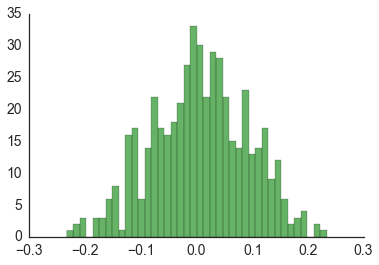

In [8]:
B_pbs = 500

meanvals_pbs = np.empty(B_pbs)

rd.seed(255747)
poisson1 = stats.poisson(1)

for idx in range(B_pbs):
    pois_dist = poisson1.rvs(size=N)
    index_list = np.empty(np.sum(pois_dist), dtype=int)
    fill_ind = 0
    for Nind in range(N):
        # There might be a more graceful way to doing this
        num_to_fill = pois_dist[Nind]
        index_list[fill_ind:fill_ind+num_to_fill] = Nind
        fill_ind += num_to_fill
    Dsample = X[index_list]
    meanvals_pbs[idx] = Dsample.mean()

print('Mean of Poisson bootstrapped mean is %.4f' % meanvals_pbs.mean())
print('Standard deviation on Poisson bootstrapped mean is %.4f' % meanvals_pbs.std())
    
plt.hist(meanvals_bs, bins=40, facecolor='g', alpha=.6)
plt.tick_params(labelsize=14)
sns.despine()

In [9]:
# print(pois_dist)
# print(np.sum(pois_dist))

### Moving block bootstrap

Künsch, H. R. (1989). “The jackknife and the bootstrap for general stationary observations,” Annals of Statistics, 17, 1217–1241 [link](https://projecteuclid.org/download/pdf_1/euclid.aos/1176347265)

Now we get to deal with data that is not necessarily IID and follows in a time-series. We will, however assume that the process to generate the data is stationary--the process does *not* change over time.

The bootstrap works as follows: For our sample of length $N$, we'll pick $L$ continous sub-samples of length $N/L$ (or some rounded value thereof...). Pick the subsamples with replacement (much like for regular bootstrap). Run your statistics as before, and do the bootstrap a whole bunch of times. This will similarly give you some indication of how your estimate was.

For a simple model, let's try a $AR(1)$ process, where

$$X_{t+1} = \beta X_t + \epsilon$$

$\epsilon$ is some noise process, where we will draw from a $Normal(0,1)$ distribution, and $\beta$ is our mixing parameter that we want to figure out from data.

In [10]:
beta_AR1 = 0.75

N_time = 1000
T_val = range(N_time)
zero_level = np.zeros(N_time)

rd.seed(4514)
AR1_jumps = rd.randn(N_time)
X_time = np.zeros(N_time)
for idx in range(N_time - 1):
    X_time[idx+1] = beta_AR1*X_time[idx] + AR1_jumps[idx]

/Users/anzelp/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


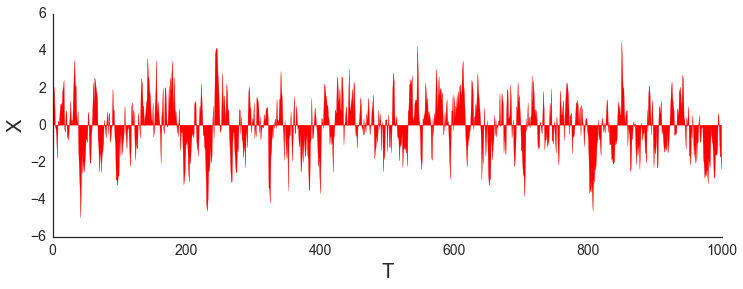

In [11]:
# Redo figure to fill in to zero
plt.figure(figsize=(12,4))
plt.fill_between(T_val, X_time, y2=zero_level, color='r')
plt.xlabel('T', fontsize=20)
plt.ylabel('X', fontsize=20)
plt.tick_params(labelsize=14)
sns.despine()

In [12]:
# Making our bootstrap
L_mbbs = 10

X_mbbs = np.zeros(N_time)
subset_length = int(N_time/L_mbbs)

from numpy.matlib import repmat
X_time_draw = repmat(X_time, 1, 2).ravel()

for idx in range(L_mbbs):
    start_idx = rd.randint(N_time)
    X_mbbs[subset_length*idx:subset_length*(idx+1)] = \
        X_time_draw[start_idx:(start_idx+subset_length)]

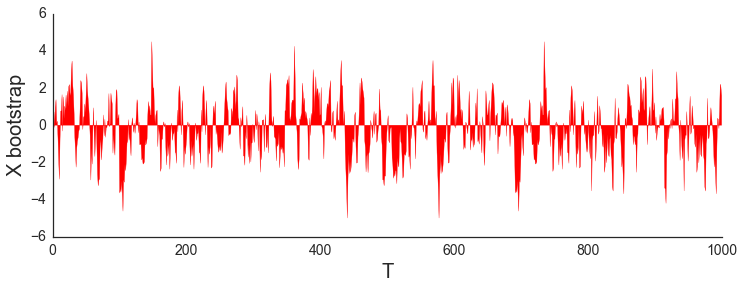

In [13]:
plt.figure(figsize=(12,4))
plt.fill_between(T_val, X_mbbs, y2=zero_level, color='r')
plt.xlabel('T', fontsize=20)
plt.ylabel('X bootstrap', fontsize=20)
plt.tick_params(labelsize=14)
sns.despine()

To estimate $\beta$, a least squares estimate tries to minimize the summed squares of $X_t - \beta X_{t_1}$, letting $\frac{d}{d \beta} \text{summed squares} = 0$. With a little rearranging$^*$ we get the equation to solve for:

$$\hat \beta = \frac{\Sigma_{k=2}^N X_k X_{k-1}}{\Sigma_{k=2}^N X_{k-1}^2}$$

$^*$ http://www.math.utah.edu/~zhorvath/ar1.pdf

In [14]:
# beta estimate for X_time
beta_hat = np.dot(X_time[1:], X_time[:-1])/np.dot(X_time[:-1], X_time[:-1])

print('Beta_hat on data = %.3f' % beta_hat)

beta_hat = np.dot(X_mbbs[1:], X_mbbs[:-1])/np.dot(X_mbbs[:-1], X_mbbs[:-1])

print('Beta_hat on one bootstrap = %.3f' % beta_hat)

Beta_hat on data = 0.750
Beta_hat on one bootstrap = 0.741


Mean of beta_hat estimate: 0.740
Standard dev of beta_hat estimate: 0.020


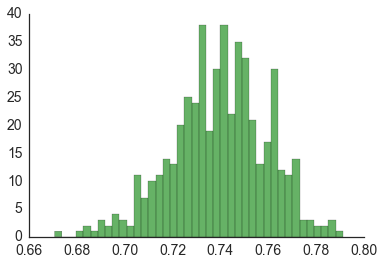

In [15]:
# Run bootstrap
B_time = 500
L_mbbs = 10
X_mbbs = np.zeros(N_time)
subset_length = int(N_time/L_mbbs)
Beta_hat_est = np.empty(B_time)

rd.seed(1729)
for ind in range(B_time):
    for idx in range(L_mbbs):
        start_idx = rd.randint(N_time)
        X_mbbs[subset_length*idx:subset_length*(idx+1)] = \
            X_time_draw[start_idx:(start_idx+subset_length)]
    Beta_hat_est[ind] = np.dot(X_mbbs[1:], X_mbbs[:-1])/np.dot(X_mbbs[:-1], X_mbbs[:-1])

plt.hist(Beta_hat_est, bins=40, facecolor='g', alpha=.6)
print('Mean of beta_hat estimate: %.3f' % Beta_hat_est.mean())
print('Standard dev of beta_hat estimate: %.3f' % Beta_hat_est.std())
plt.tick_params(labelsize=14)
sns.despine()

Additional analysis would also look at the shape of our random jump distribution for $\epsilon$, but you can do that on your own.

We're going to want $L << N$ as our result gets more and more biased (since we have more discontinuities--weird data transitions) to estimate our parameter. If we were naive and had $L = N$ (this would be the standard bootstrap) here's what we'd get: 

Mean of beta_hat estimate: 0.003
Standard dev of beta_hat estimate: 0.032


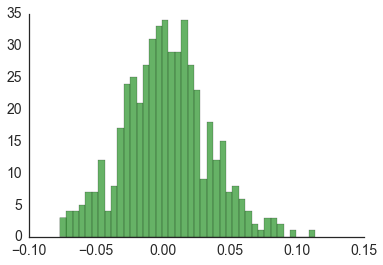

In [16]:
# Being dumb about things
B_time = 500
L_mbbs = N_time
X_mbbs = np.zeros(N_time)
subset_length = int(N_time/L_mbbs)
Beta_hat_est = np.empty(B_time)

rd.seed(1729)
for ind in range(B_time):
    for idx in range(L_mbbs):
        start_idx = rd.randint(N_time)
        X_mbbs[subset_length*idx:subset_length*(idx+1)] = \
            X_time_draw[start_idx:(start_idx+subset_length)]
    Beta_hat_est[ind] = np.dot(X_mbbs[1:], X_mbbs[:-1])/np.dot(X_mbbs[:-1], X_mbbs[:-1])

plt.hist(Beta_hat_est, bins=40, facecolor='g', alpha=.6)
print('Mean of beta_hat estimate: %.3f' % Beta_hat_est.mean())
print('Standard dev of beta_hat estimate: %.3f' % Beta_hat_est.std())
plt.tick_params(labelsize=14)
sns.despine()

In [17]:
L_test = np.array([2, 4, 5, 10, 20, 40, 50, 100, 250, 500, 1000])
LargeB_time = 2000

beta_by_L_std = np.zeros(len(L_test))
beta_by_L_bias = np.zeros(len(L_test))
rd.seed(1729)

for L_ind in range(len(L_test)):
    L_mbbs = L_test[L_ind]
    X_mbbs = np.zeros(N_time)
    subset_length = int(N_time/L_mbbs)
    Beta_hat_est = np.empty(LargeB_time)
    for ind in range(LargeB_time):
        for idx in range(L_mbbs):
            start_idx = rd.randint(N_time)
            X_mbbs[subset_length*idx:subset_length*(idx+1)] = \
                X_time_draw[start_idx:(start_idx+subset_length)]
        Beta_hat_est[ind] = np.dot(X_mbbs[1:], X_mbbs[:-1])/np.dot(X_mbbs[:-1], X_mbbs[:-1])
    beta_by_L_std[L_ind] = Beta_hat_est.std()
    beta_by_L_bias[L_ind] = beta_AR1 - Beta_hat_est.mean()

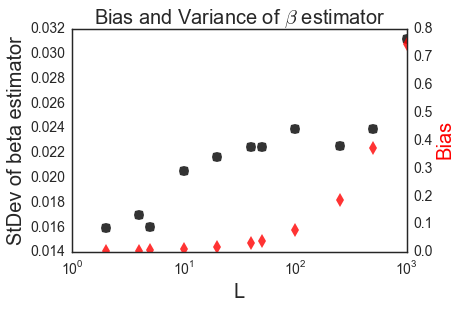

In [23]:
fig, ax1 = plt.subplots()

ax1.semilogx(L_test, beta_by_L_std, color='k', marker='o', markersize=10,
             alpha=.8, linestyle='', label='StDev')
ax1.set_xlabel('L', fontsize=20)
ax1.set_ylabel('StDev of beta estimator', fontsize=20)
ax1.tick_params(labelsize=14)
ax1.set_title(r'Bias and Variance of $\beta$ estimator', fontsize=20)

ax2 = ax1.twinx()
ax2.semilogx(L_test, beta_by_L_bias, color='r', marker='d', markersize=10,
             alpha=.8, linestyle='', label='Bias')
ax2.set_ylabel('Bias', fontsize=20, color='r')
ax2.tick_params(labelsize=14)

So it looks like you really want $L$ to be rather small. I don't know of any particular reason not to let $L$ be as small as possible, but I'm sure there's some competing logic...

In any case, a more popular method now varies the size of the blocks used with a geometric distribution. The last reference describes this technique more in detail.

Additional references:
- [Everything you wanted to know about Data Analysis and Fitting but were afraid to ask](http://arxiv.org/pdf/1210.3781.pdf)
- [Estimating Uncertainity for Massive Data Streams](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43157.pdf)
- [Bootstrap for dependent data (other methods for dealing with time series bootstrap)](http://sfb649.wiwi.hu-berlin.de/fedc_homepage/xplore/ebooks/html/csa/node132.html)
- [The Impact of Bootstrap Methods on Time Series Analysis](http://projecteuclid.org/download/pdf_1/euclid.ss/1063994977)